# torchCFM

In [1]:
%load_ext autoreload
%autoreload 2
import os

import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import torch
import torchsde
from torchdyn.core import NeuralODE
from tqdm import tqdm

from torchcfm.conditional_flow_matching import *
from torchcfm.models import MLP
from torchcfm.utils import SDE, plot_trajectories, torch_wrapper

savedir = "models/single-cell"
os.makedirs(savedir, exist_ok=True)

In [2]:
# adata = sc.read_h5ad("../data/ebdata_v2.h5ad")
adata = sc.read_h5ad(os.path.join("/Users/paul/PycharmProjects/FLeCS",
                                  "datasets", "Paul15", "processed", "adata_processed_with_paths_magic.h5ad")
                     )
adata

/Users/paul/miniconda3/envs/cfm/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 7296 × 4000
    obs: 'index', 'Seq_batch_ID', 'Amp_batch_ID', 'well_coordinates', 'Mouse_ID', 'Plate_ID', 'Batch_desc', 'Pool_barcode', 'Cell_barcode', 'RMT_sequence', 'Number_of_cells', 'CD34_measurement', 'FcgR3_measurement', 'n_counts_all', 'n_counts'
    var: 'n_counts', 'highly_variable'
    uns: 'cebpa_ko_shortest_paths', 'cebpe_ko_shortest_paths', 'neighbors', 'pca', 'umap', 'unsorted_shortest_paths'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'
    varp: 'grn_adj_mat'

In [3]:
adata = adata[adata.obs["Batch_desc"].apply(lambda x: x in ['CMP Flt3+ Csf1r+', 'Unsorted myeloid'])].copy()

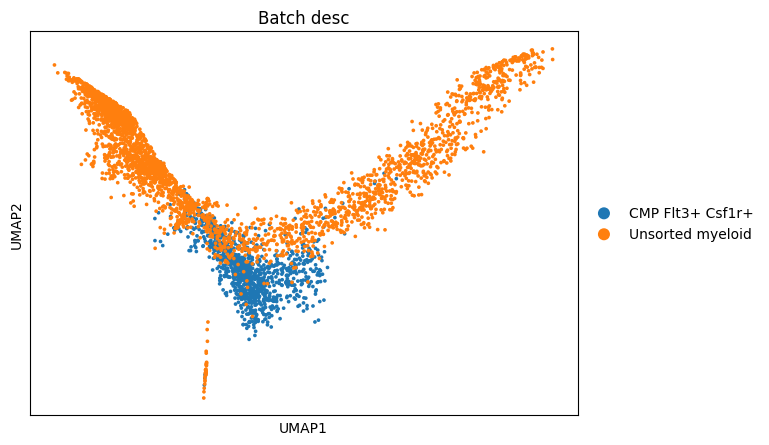

In [4]:
sc.pl.scatter(adata, basis="umap", color="Batch_desc")

In [11]:
n_times = len(adata.obs["Batch_desc"].unique())
# Standardize coordinates
coords = adata.obsm["X_umap"]
coords = (coords - coords.mean(axis=0)) / coords.std(axis=0)
adata.obsm["X_umap_standardized"] = coords
X = [
    adata.obsm["X_umap_standardized"][adata.obs["Batch_desc"].cat.codes == t]
    for t in range(n_times)
]

In [23]:
n_times = len(adata.obs["Batch_desc"].unique())
# Standardize coordinates
coords = adata.X
coords = (coords - coords.mean(axis=0)) / coords.std(axis=0)
adata.obsm["X_standardized"] = coords
X = [adata.obsm["X_standardized"][adata.obs["Batch_desc"].cat.codes == t] for t in range(n_times)]

In [39]:
torch.Tensor(adata.obs["Batch_desc"].cat.codes)[:, None]

tensor([[1.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]])

In [17]:
adata.obs["Batch_desc"]

0       Unsorted myeloid
1       Unsorted myeloid
2       Unsorted myeloid
3       Unsorted myeloid
4       Unsorted myeloid
              ...       
5755    CMP Flt3+ Csf1r+
5756    CMP Flt3+ Csf1r+
5757    CMP Flt3+ Csf1r+
5758    CMP Flt3+ Csf1r+
5759    CMP Flt3+ Csf1r+
Name: Batch_desc, Length: 4224, dtype: category
Categories (2, object): ['CMP Flt3+ Csf1r+', 'Unsorted myeloid']

In [27]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 256
sigma = 0.1
dim = 4000
ot_cfm_model = MLP(dim=dim, time_varying=True, w=64).to(device)
ot_cfm_optimizer = torch.optim.Adam(ot_cfm_model.parameters(), 1e-4)
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)

In [50]:
import scprep


def plot_trajectories(traj, legend=True):
    n = 2000
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    scprep.plot.scatter(
        adata.obsm["X_standardized"][:, 0],
        adata.obsm["X_standardized"][:, 1],
        c=adata.obs["Batch_desc"],
        ax=ax,
    )
    # ax.scatter(traj[0, :n, 0], traj[0, :n, 1], s=10, alpha=0.8, c="black")
    ax.scatter(traj[:, :n, 0], traj[:, :n, 1], s=0.4, alpha=0.1, c="olive")
    # ax.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue")

    for i in range(15):
        ax.plot(traj[:, i, 0], traj[:, i, 1], alpha=0.9, c="red")
    if legend:
        plt.legend([r"$p_0$", r"$p_t$", r"$p_1$", r"$X_t \mid X_0$"])
    # plt.xticks([])
    # plt.yticks([])
    # plt.axis("off")


def get_batch(FM, X, batch_size, n_times, return_noise=False):
    """Construct a batch with point sfrom each timepoint pair"""
    ts = []
    xts = []
    uts = []
    noises = []
    for t_start in range(n_times - 1):
        x0 = (
            torch.from_numpy(X[t_start][np.random.randint(X[t_start].shape[0], size=batch_size)])
            .float()
            .to(device)
        )
        x1 = (
            torch.from_numpy(
                X[t_start + 1][np.random.randint(X[t_start + 1].shape[0], size=batch_size)]
            )
            .float()
            .to(device)
        )
        if return_noise:
            t, xt, ut, eps = FM.sample_location_and_conditional_flow(
                x0, x1, return_noise=return_noise
            )
            noises.append(eps)
        else:
            t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1, return_noise=return_noise)
        ts.append(t + t_start)
        xts.append(xt)
        uts.append(ut)
    t = torch.cat(ts)
    xt = torch.cat(xts)
    ut = torch.cat(uts)
    if return_noise:
        noises = torch.cat(noises)
        return t, xt, ut, noises
    return t, xt, ut

## OT-CFM

In [29]:
for i in tqdm(range(10000)):
    ot_cfm_optimizer.zero_grad()
    t, xt, ut = get_batch(FM, X, batch_size, n_times)
    vt = ot_cfm_model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)
    loss.backward()
    ot_cfm_optimizer.step()

100%|██████████| 10000/10000 [07:39<00:00, 21.76it/s]


In [58]:
torch.cat([torch.from_numpy(coords), 
           torch.Tensor(adata.obs["Batch_desc"].cat.codes)[:, None]], 
           dim=-1).float()

tensor([[-1.0378, -0.0505,  0.0903,  ...,  1.1486, -0.3858,  1.0000],
        [-0.4991,  0.1447, -0.8091,  ..., -0.8065, -0.7076,  1.0000],
        [-0.1603, -0.1540,  1.0801,  ..., -1.2936,  0.0433,  1.0000],
        ...,
        [ 0.7183, -0.0458, -0.1331,  ...,  0.9817,  0.7819,  0.0000],
        [ 0.5506, -0.2246, -0.0398,  ...,  0.8211,  0.0081,  0.0000],
        [ 0.6174,  1.0242, -0.1953,  ...,  0.6553,  0.3552,  0.0000]])

In [59]:
vt = ot_cfm_model(
    torch.cat([torch.from_numpy(coords), 
           torch.Tensor(adata.obs["Batch_desc"].cat.codes)[:, None]], 
           dim=-1).float())

In [61]:
vt.shape

torch.Size([4224, 4000])

In [52]:
node = NeuralODE(torch_wrapper(ot_cfm_model), solver="dopri5", sensitivity="adjoint")
with torch.no_grad():
    traj = node.trajectory(
        torch.from_numpy(X[0][:1000]).float().to(device),
        t_span=torch.linspace(0, n_times - 1, 400),
    ).cpu()

In [70]:
adata.obsm['OT_CFM_velocity'] = vt.detach().numpy()

In [72]:
adata.write_h5ad('/Users/paul/PycharmProjects/FLeCS/figure2/processed/adata_ot_cfm.h5ad')

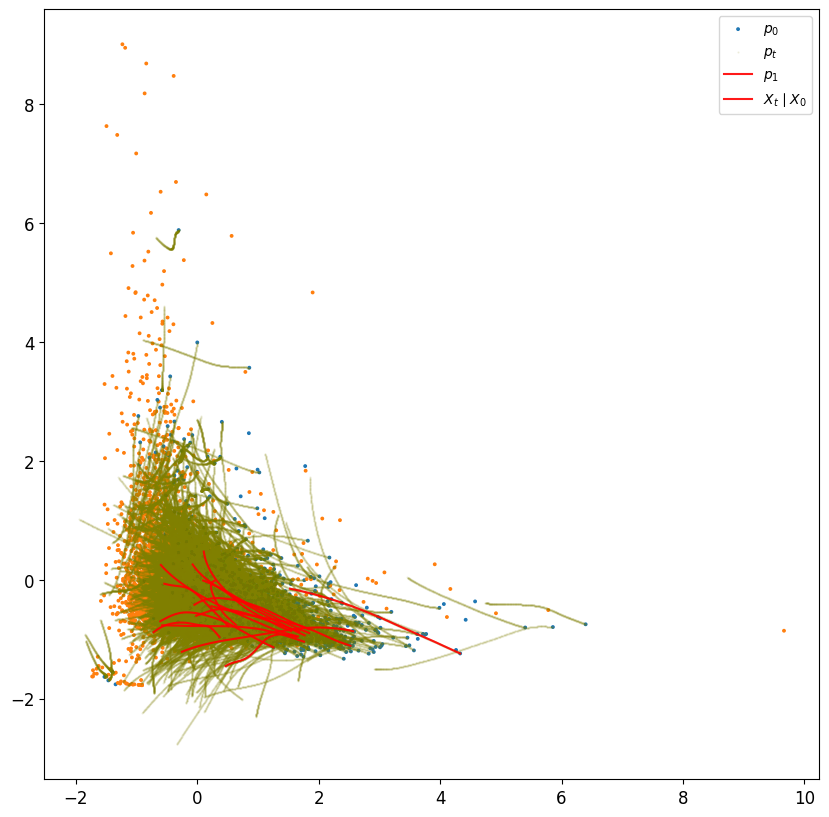

In [53]:
plot_trajectories(traj.cpu().numpy())